# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

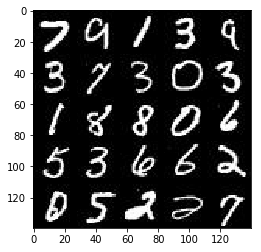

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

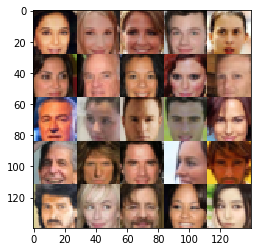

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests
import tensorflow as tf

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_width, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, drop_rate=0.5):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    kernel_initializer = tf.truncated_normal_initializer(stddev=0.02, dtype=tf.float32)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        layer1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)
        # Leaky ReLU
        layer1 = tf.maximum(alpha * layer1, layer1)
        # dropout
        layer1 = tf.layers.dropout(layer1, rate=drop_rate)
        # 14 x 14 x 64
        
        layer2 = tf.layers.conv2d(layer1, filters=128, kernel_size=5, strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)
        # Batch Normalization
        layer2 = tf.contrib.layers.batch_norm(layer2, is_training=True)
        # Leaky ReLU
        layer2 = tf.maximum(alpha * layer2, layer2)
        # dropout
        layer2 = tf.layers.dropout(layer2, rate=drop_rate)
        # 7 x 7 x 128
        
        layer3 = tf.layers.conv2d(layer2, filters=256, kernel_size=5, strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)
        # Batch Normalization
        layer3 = tf.contrib.layers.batch_norm(layer3, is_training=True)
        # Leaky ReLU
        layer3 = tf.maximum(alpha * layer3, layer3)
        # dropout
        layer3 = tf.layers.dropout(layer3, rate=drop_rate)
        # 4 x 4 x 256

        layer_flatten = tf.reshape(layer3, (-1, 4*4*256))
        logits = tf.layers.dense(layer_flatten, 1)

        out = tf.nn.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, drop_rate=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    kernel_initializer = tf.truncated_normal_initializer(stddev=0.02, dtype=tf.float32)
    
    # According to the forum, reuse = not is_train should be used because we want to reuse the parameters 
    # when we are generating the samples but that will not be during the training.
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        layer1 = tf.layers.dense(z, 7*7*512, kernel_initializer=kernel_initializer)
        # Reshape it to start the convolutional stack
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)
        layer1 = tf.layers.dropout(layer1, rate=drop_rate)
        # print('layer1', layer1)
        # 7x7x512 now
                
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides=2, padding='same', kernel_initializer=kernel_initializer)
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        layer2 = tf.layers.dropout(layer2, rate=drop_rate)
        # print('layer2', layer2)
        # 14x14x256 now

        # Output layer
        logits = tf.layers.conv2d_transpose(layer2, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=kernel_initializer)
        # print('logits', logits)
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth = 0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Label smoothing 
    labels_real = tf.ones_like(d_logits_real) * (1 - smooth)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=labels_real))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    steps = 0
    print_every = 100
    show_every = 100
    show_n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images * 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images, learn_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, inputs_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9369... Generator Loss: 1.5777


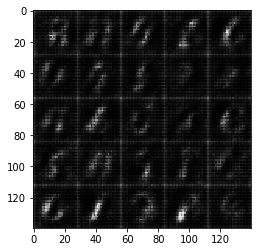

Epoch 1/2... Discriminator Loss: 0.9233... Generator Loss: 1.4813


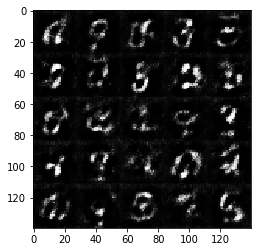

Epoch 1/2... Discriminator Loss: 0.7491... Generator Loss: 1.4947


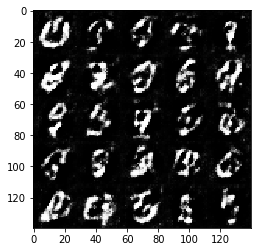

Epoch 1/2... Discriminator Loss: 0.7631... Generator Loss: 1.2543


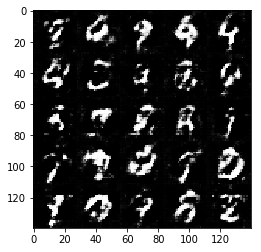

Epoch 1/2... Discriminator Loss: 0.7763... Generator Loss: 2.5793


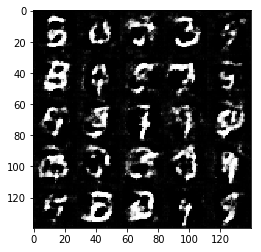

Epoch 1/2... Discriminator Loss: 1.1873... Generator Loss: 3.3813


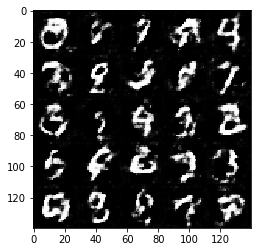

Epoch 1/2... Discriminator Loss: 0.7007... Generator Loss: 1.6926


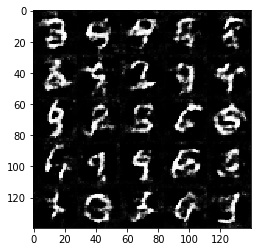

Epoch 1/2... Discriminator Loss: 1.0888... Generator Loss: 0.7655


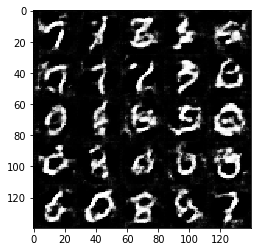

Epoch 1/2... Discriminator Loss: 1.0408... Generator Loss: 0.8267


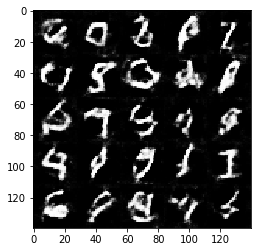

Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 0.8749


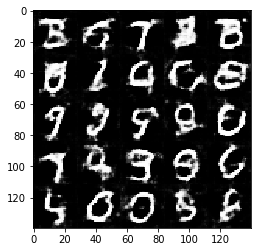

Epoch 1/2... Discriminator Loss: 1.3408... Generator Loss: 0.5344


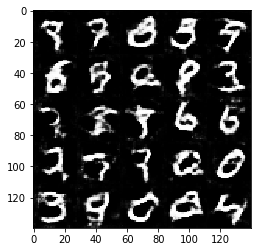

Epoch 1/2... Discriminator Loss: 0.8785... Generator Loss: 1.0863


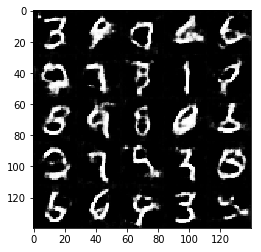

Epoch 1/2... Discriminator Loss: 0.7841... Generator Loss: 2.1561


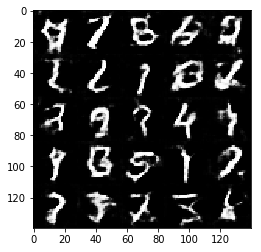

Epoch 1/2... Discriminator Loss: 0.7942... Generator Loss: 1.3009


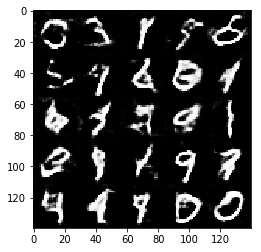

Epoch 1/2... Discriminator Loss: 0.8555... Generator Loss: 1.1230


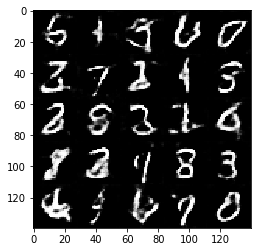

Epoch 1/2... Discriminator Loss: 0.6792... Generator Loss: 1.6960


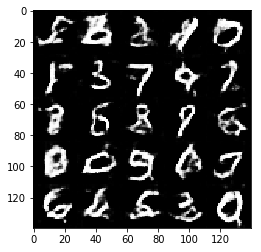

Epoch 1/2... Discriminator Loss: 0.8220... Generator Loss: 1.1112


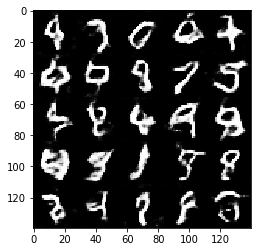

Epoch 1/2... Discriminator Loss: 0.6235... Generator Loss: 1.7075


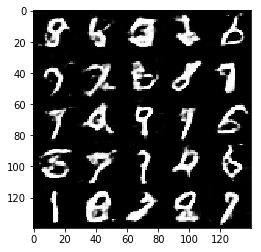

Epoch 2/2... Discriminator Loss: 1.0767... Generator Loss: 2.3296


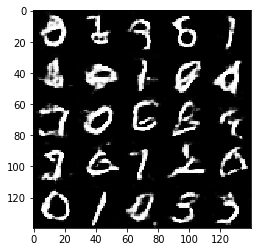

Epoch 2/2... Discriminator Loss: 0.6566... Generator Loss: 1.7774


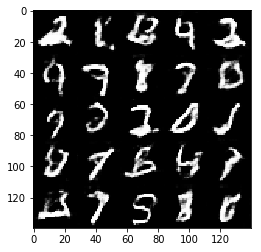

Epoch 2/2... Discriminator Loss: 0.6446... Generator Loss: 1.5270


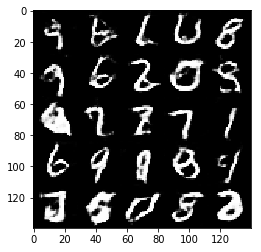

Epoch 2/2... Discriminator Loss: 0.8684... Generator Loss: 1.0216


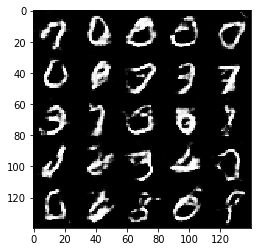

Epoch 2/2... Discriminator Loss: 0.6218... Generator Loss: 1.5543


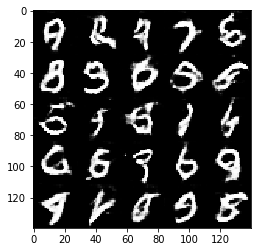

Epoch 2/2... Discriminator Loss: 0.5492... Generator Loss: 2.0363


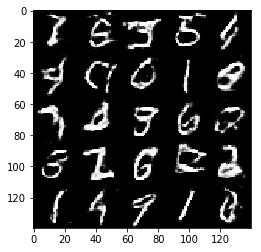

Epoch 2/2... Discriminator Loss: 0.9223... Generator Loss: 0.9647


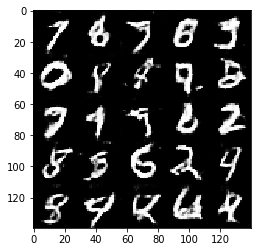

Epoch 2/2... Discriminator Loss: 0.7312... Generator Loss: 1.2654


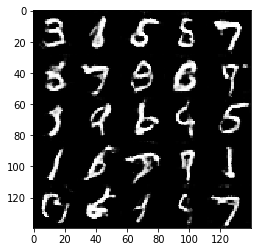

Epoch 2/2... Discriminator Loss: 0.6041... Generator Loss: 1.9428


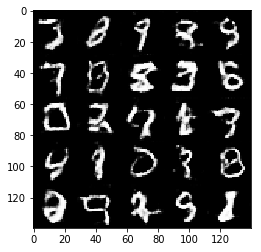

Epoch 2/2... Discriminator Loss: 0.6773... Generator Loss: 1.4897


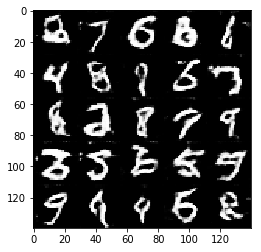

Epoch 2/2... Discriminator Loss: 0.9912... Generator Loss: 0.8971


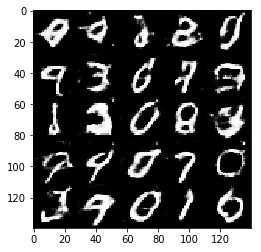

Epoch 2/2... Discriminator Loss: 0.6916... Generator Loss: 1.5185


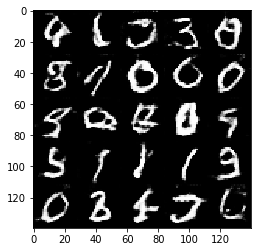

Epoch 2/2... Discriminator Loss: 0.6147... Generator Loss: 1.7047


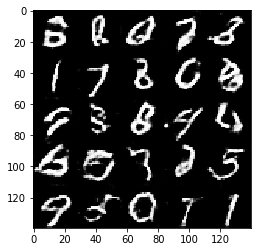

Epoch 2/2... Discriminator Loss: 0.5700... Generator Loss: 1.8343


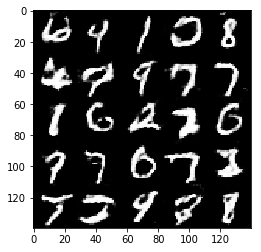

Epoch 2/2... Discriminator Loss: 0.8555... Generator Loss: 1.0565


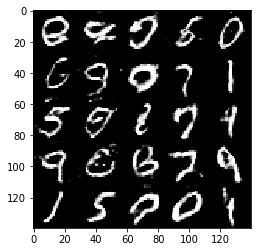

Epoch 2/2... Discriminator Loss: 0.5003... Generator Loss: 2.2034


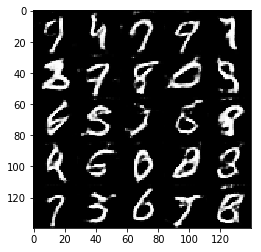

Epoch 2/2... Discriminator Loss: 0.6448... Generator Loss: 1.6100


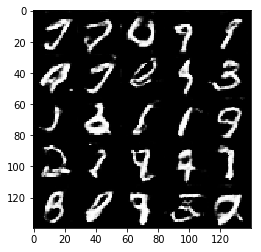

Epoch 2/2... Discriminator Loss: 0.7314... Generator Loss: 2.3150


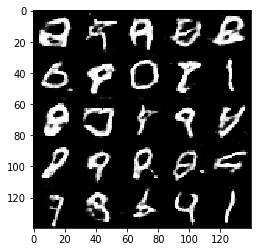

Epoch 2/2... Discriminator Loss: 0.5833... Generator Loss: 1.6562


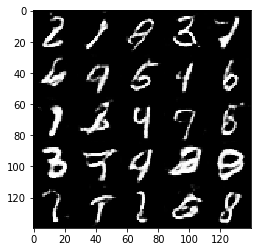

In [12]:
batch_size = 32 # Try values like 16 to 32 for better results 
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6780... Generator Loss: 2.4348


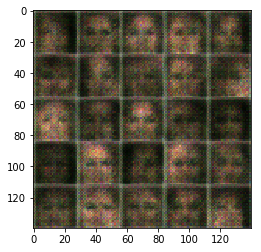

Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.9646


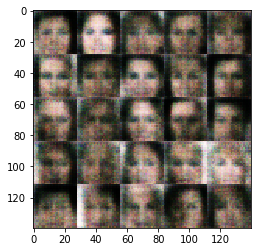

Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.8913


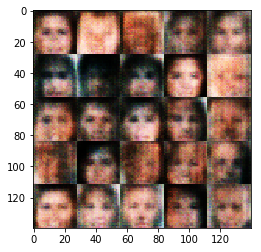

Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 1.3343


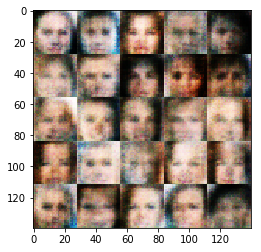

Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.6711


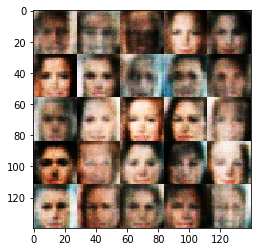

Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 1.4911


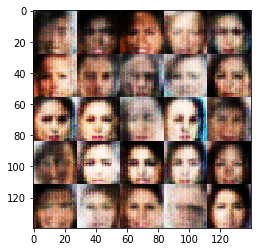

Epoch 1/1... Discriminator Loss: 0.7551... Generator Loss: 5.1575


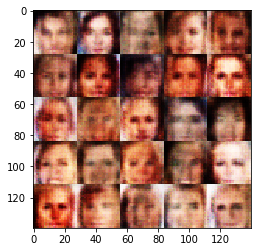

Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 3.3177


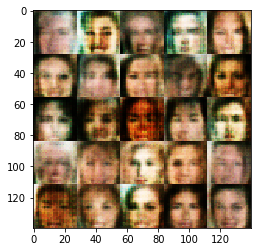

Epoch 1/1... Discriminator Loss: 0.3521... Generator Loss: 6.1738


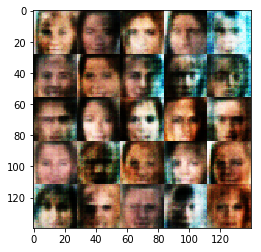

Epoch 1/1... Discriminator Loss: 0.6042... Generator Loss: 1.5669


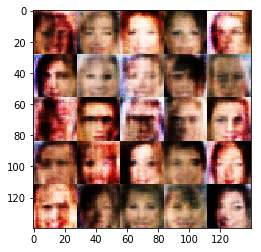

Epoch 1/1... Discriminator Loss: 0.3465... Generator Loss: 7.4802


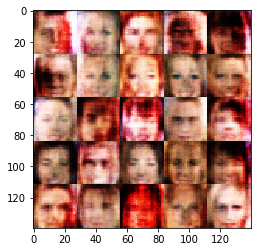

Epoch 1/1... Discriminator Loss: 0.3621... Generator Loss: 7.9089


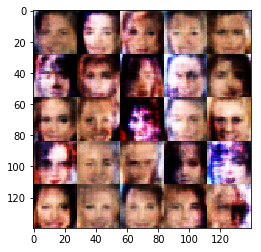

Epoch 1/1... Discriminator Loss: 0.3394... Generator Loss: 7.0909


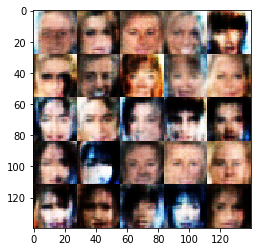

Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 3.7168


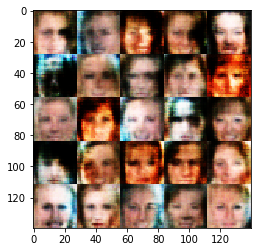

Epoch 1/1... Discriminator Loss: 0.3360... Generator Loss: 7.9797


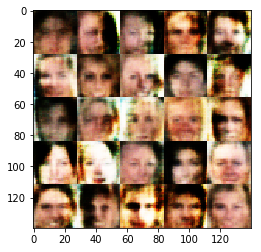

Epoch 1/1... Discriminator Loss: 0.3461... Generator Loss: 11.2473


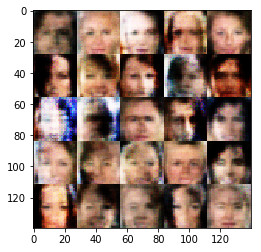

Epoch 1/1... Discriminator Loss: 0.3354... Generator Loss: 6.3057


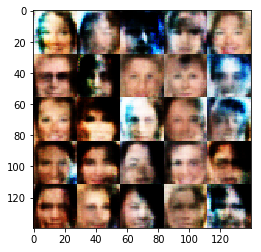

Epoch 1/1... Discriminator Loss: 0.3682... Generator Loss: 8.7270


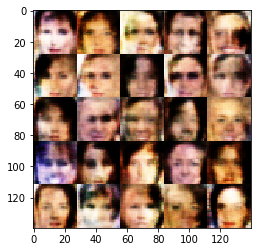

Epoch 1/1... Discriminator Loss: 2.1611... Generator Loss: 5.9721


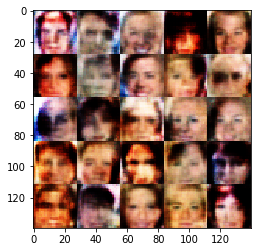

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 9.9327


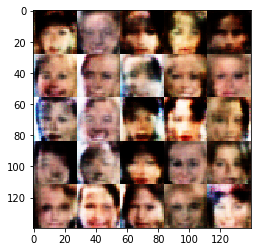

Epoch 1/1... Discriminator Loss: 0.4562... Generator Loss: 2.3889


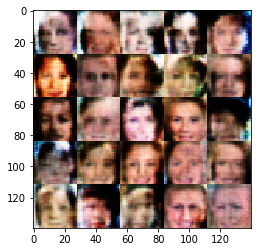

Epoch 1/1... Discriminator Loss: 0.3597... Generator Loss: 3.9256


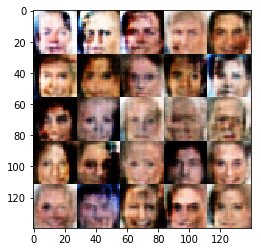

Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 7.9479


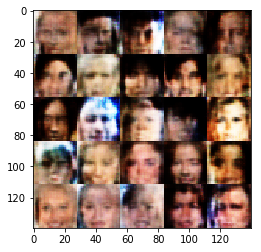

Epoch 1/1... Discriminator Loss: 0.3366... Generator Loss: 5.9841


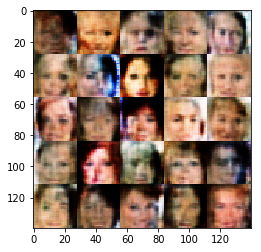

Epoch 1/1... Discriminator Loss: 0.4727... Generator Loss: 2.1357


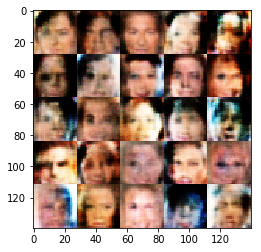

Epoch 1/1... Discriminator Loss: 0.3535... Generator Loss: 7.0577


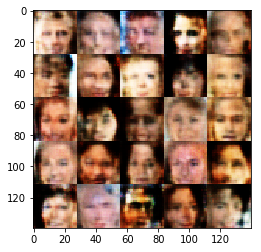

Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 0.8674


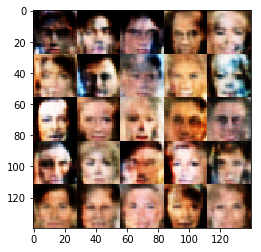

Epoch 1/1... Discriminator Loss: 0.3374... Generator Loss: 6.0719


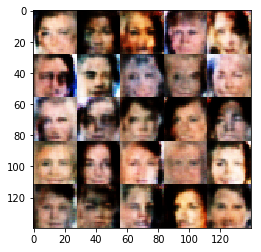

Epoch 1/1... Discriminator Loss: 0.3386... Generator Loss: 9.0252


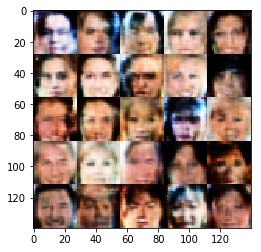

Epoch 1/1... Discriminator Loss: 0.5286... Generator Loss: 9.9586


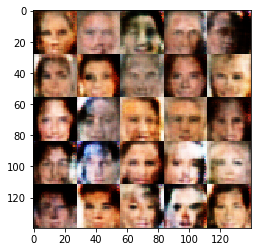

Epoch 1/1... Discriminator Loss: 0.3468... Generator Loss: 4.8070


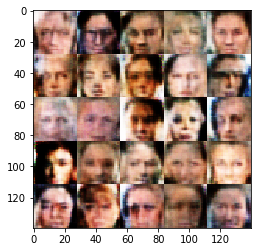

Epoch 1/1... Discriminator Loss: 0.4375... Generator Loss: 2.4083


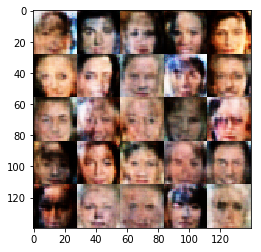

Epoch 1/1... Discriminator Loss: 0.4438... Generator Loss: 2.8431


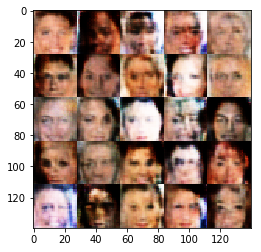

Epoch 1/1... Discriminator Loss: 0.3622... Generator Loss: 3.8754


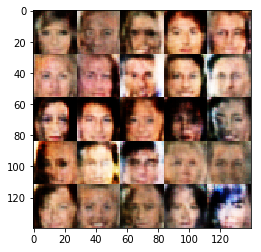

Epoch 1/1... Discriminator Loss: 0.3361... Generator Loss: 7.1097


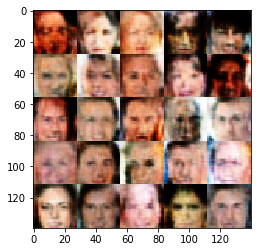

Epoch 1/1... Discriminator Loss: 0.8317... Generator Loss: 1.1649


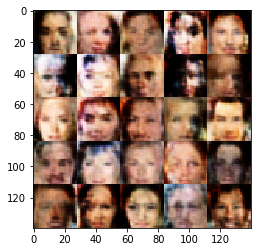

Epoch 1/1... Discriminator Loss: 0.3584... Generator Loss: 5.8894


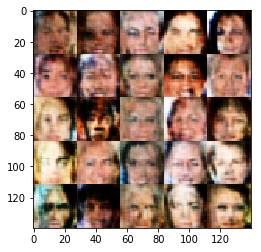

Epoch 1/1... Discriminator Loss: 0.3815... Generator Loss: 3.8206


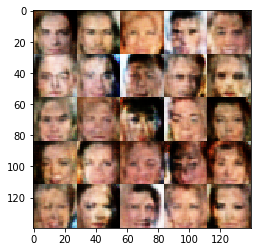

Epoch 1/1... Discriminator Loss: 3.2528... Generator Loss: 6.0785


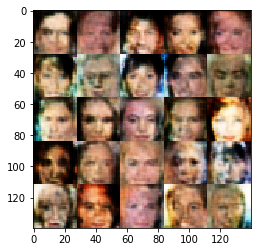

Epoch 1/1... Discriminator Loss: 0.3618... Generator Loss: 5.7758


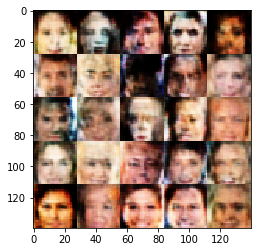

Epoch 1/1... Discriminator Loss: 0.3732... Generator Loss: 3.5091


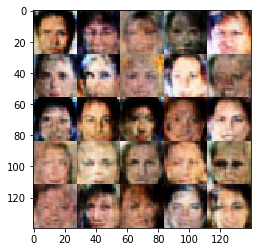

Epoch 1/1... Discriminator Loss: 0.3517... Generator Loss: 8.2241


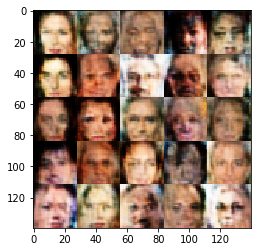

Epoch 1/1... Discriminator Loss: 0.3416... Generator Loss: 5.9335


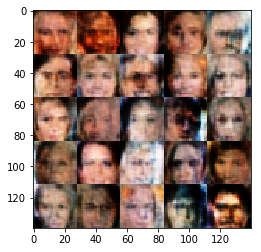

Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 2.6998


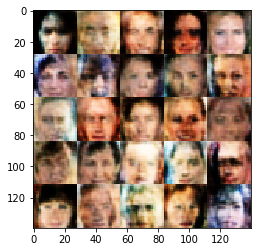

Epoch 1/1... Discriminator Loss: 0.4420... Generator Loss: 10.5324


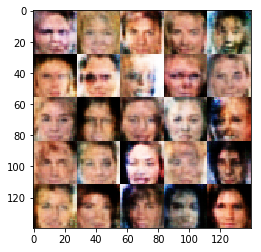

Epoch 1/1... Discriminator Loss: 0.3539... Generator Loss: 7.3554


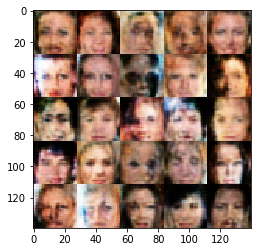

Epoch 1/1... Discriminator Loss: 0.3405... Generator Loss: 5.9900


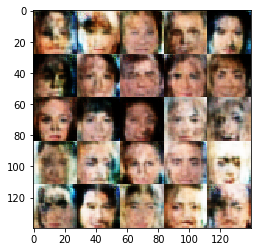

Epoch 1/1... Discriminator Loss: 0.3525... Generator Loss: 5.4629


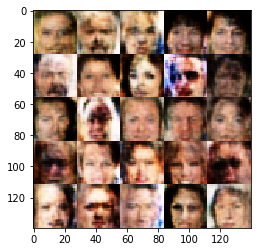

Epoch 1/1... Discriminator Loss: 0.3616... Generator Loss: 3.8474


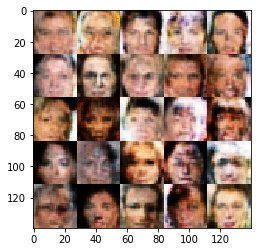

Epoch 1/1... Discriminator Loss: 0.3459... Generator Loss: 7.8700


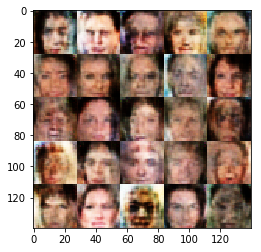

Epoch 1/1... Discriminator Loss: 0.3736... Generator Loss: 3.8373


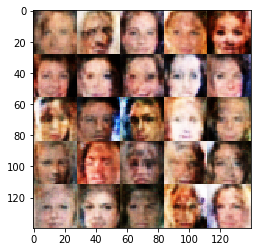

Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 3.8105


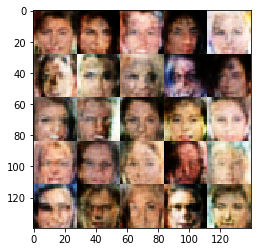

Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 0.8518


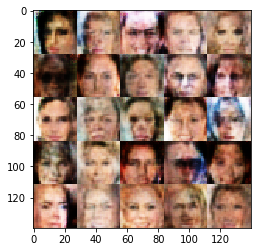

Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 1.2081


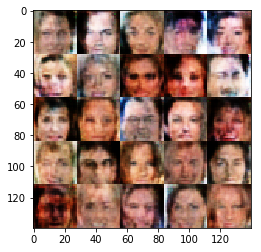

Epoch 1/1... Discriminator Loss: 0.3820... Generator Loss: 4.4675


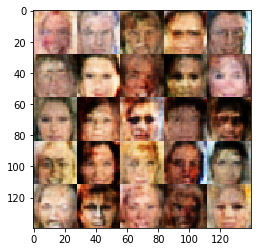

Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 2.5190


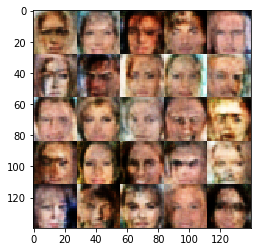

Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 5.1550


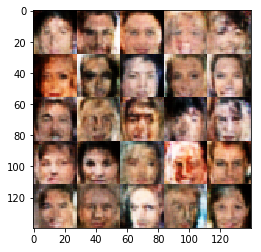

Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.5218


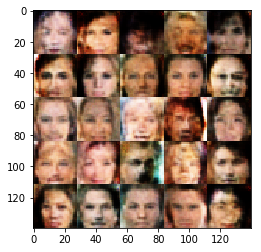

Epoch 1/1... Discriminator Loss: 0.3773... Generator Loss: 3.7398


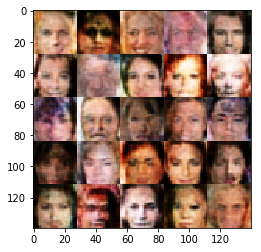

Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 1.9522


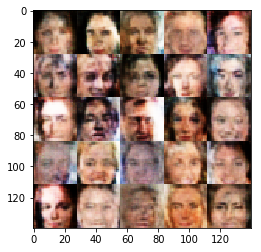

Epoch 1/1... Discriminator Loss: 0.3535... Generator Loss: 4.5065


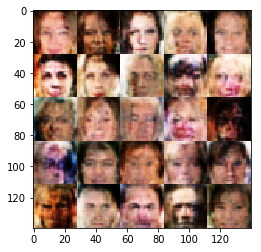

Epoch 1/1... Discriminator Loss: 0.4210... Generator Loss: 3.1373


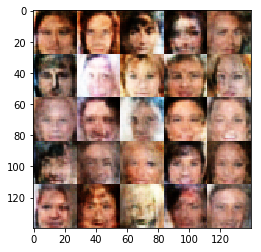

Epoch 1/1... Discriminator Loss: 0.3750... Generator Loss: 3.9090


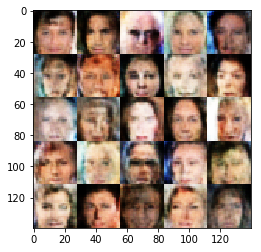

In [12]:
batch_size = 32 # Try values like 16 to 32 for better results 
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.